In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from importlib import reload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
pd.options.display.max_columns = 999
pd.options.display.max_rows = 99
import ReadFromDB as RDB
import statsmodels.api as sm
%matplotlib inline

In [51]:
def station_function(i):
    """
    Creates a sparse matrix from station information on database
    """
    
    station = RDB.add_times(RDB.create_station_dictionary(i)[i])
    weather = RDB.weather_times(RDB.read_weather(i))
#     df = pd.merge(station, weather, left_on=['date', 'hour', 'first_half_hour', 'second_half_hour'], right_on=['date', 'hour', 'first_half_hour', 'second_half_hour'], how='inner')
#     df.drop_duplicates(subset='last_updated', inplace=True)
#     df.drop_duplicates(subset='time', inplace=True)
    df = pd.merge_asof(station, weather, left_on=['last_updated'], right_on=['time'], tolerance=600, direction='nearest')
    df = df.dropna()
    df = df.reset_index()
    df.drop('index', axis=1, inplace=True)
    
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    weather_icons = ['partly-cloudy-day',
                     'partly-cloudy-night',
                     'clear-night',
                     'clear-day',
                     'fog',
                     'wind',
                     'cloudy',
                     'rain'
                    ]
    weather_cols = ['apparentTemperature',
                    'cloudCover',
                    'dewPoint',
                    'precipProbability',
                    'pressure',
                    'windBearing',
                    'windGust',
                    'visibility'
                    ]
    
    for day in days:
        df[day] = 0
    
    for icon in weather_icons:
        df[icon] = 0
    
    for j in df.index:
        val = df.loc[j, 'day_x']
        for day in days:
            if val == day:
                df.loc[j, day] = 1
        
        icon_val = df.loc[j, 'icon']
        for icon in weather_icons:
            if icon_val == icon:
                df.loc[j, icon] = 1
     
    data = pd.DataFrame((df.Mon, df.Tue, df.Wed, df.Thu, df.Fri, df.Sat, df.Sun, df.hour_x)).T #df.first_half_hour, df.second_half_hour)).T
    
    for icon in weather_icons:
        data[icon] = df[icon]
    for col in weather_cols:
        data[col] = df[col]
   
    label = pd.DataFrame((df.available_bikes))
    
    return [df, data, label]

In [45]:
def error(predictions, labels):
    errors = list()
    new_preds = list()

    for i in predictions:
        if i<0:
            new_preds.append(0)
        elif i>20:
            new_preds.append(20)
        else:
            new_preds.append(i)
    
    for i, pred in enumerate(new_preds):
        errors.append(pred - labels[i][0])
    errors_sq = [i**2 for i in errors]
#     print("RMSE:", np.sqrt(np.mean(errors_sq)))
    return np.sqrt(np.mean(errors_sq))

In [4]:
%%time
[station, data, label] = station_function(3)

Wall time: 32.1 s


In [5]:
%%time
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.3, shuffle=False)

Wall time: 14 ms


In [6]:
scaler = StandardScaler()

In [7]:
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y_train)
Y_train = scaler.transform(y_train)
Y_test = scaler.transform(y_test)

C:\Users\Daniel\Anaconda3\envs\SE_Project\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Daniel\Anaconda3\envs\SE_Project\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
C:\Users\Daniel\Anaconda3\envs\SE_Project\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Daniel\Anaconda3\envs\SE_Project\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Daniel\Anaconda3\envs\SE_Project\lib\site-packages\ipyk

In [8]:
from sklearn.neural_network import MLPRegressor

clf = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15,), random_state=1)
clf.fit(X_train, np.array(y_train).ravel())

MLPRegressor(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(15,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [9]:
predictions = clf.predict(X_test)
labels = np.array(y_test)

In [10]:
print("\nAbs. Prediction\t-\tLabel")
for i, pred in enumerate(predictions):
    print()
    print(abs(pred), "\t-\t", "\t-\t", labels[i][0])


Abs. Prediction	-	Label

6.829920630359752 	-	 	-	 12

7.135025162418107 	-	 	-	 13

7.466369944274688 	-	 	-	 13

7.788180543673719 	-	 	-	 13

5.522355365905692 	-	 	-	 12

5.570988524934884 	-	 	-	 13

4.3527026625167435 	-	 	-	 12

5.3058581500348625 	-	 	-	 11

6.122107764147326 	-	 	-	 10

6.408914172647612 	-	 	-	 10

6.408914172647612 	-	 	-	 9

1.1702147196009665 	-	 	-	 8

4.089576778787482 	-	 	-	 7

4.178810409107039 	-	 	-	 7

4.471105170024126 	-	 	-	 7

0.5041604381104827 	-	 	-	 7

0.8240386897343464 	-	 	-	 7

2.5502819409751067 	-	 	-	 7

3.0498391005930516 	-	 	-	 7

2.866356998169926 	-	 	-	 5

2.8136780555981042 	-	 	-	 5

3.0692027151637875 	-	 	-	 5

5.184673060189259 	-	 	-	 6

4.547654635269159 	-	 	-	 5

1.1884006914683054 	-	 	-	 4

0.7356984438162746 	-	 	-	 3

3.577218916486669 	-	 	-	 3

3.577218916486669 	-	 	-	 2

3.786710044422329 	-	 	-	 2

3.48989127093819 	-	 	-	 2

4.15528294483502 	-	 	-	 3

3.083185921697898 	-	 	-	 3

2.7195003711093593 	-	 	-	 

4.716167411696646 	-	 	-	 3

4.936972062301576 	-	 	-	 3

5.0540195713267115 	-	 	-	 2

2.5603082586357013 	-	 	-	 2

3.7671018251675843 	-	 	-	 2

4.016270409736406 	-	 	-	 3

5.844801172365224 	-	 	-	 3

6.976638705840387 	-	 	-	 0

8.470059106487522 	-	 	-	 0

8.579414623942718 	-	 	-	 0

8.96711037816111 	-	 	-	 0

9.177795778204299 	-	 	-	 0

9.236228554991957 	-	 	-	 2

7.329750955242326 	-	 	-	 3

7.329750955242326 	-	 	-	 4

4.946700466102641 	-	 	-	 4

3.010277436108738 	-	 	-	 4

3.010277436108738 	-	 	-	 4

7.493807347085997 	-	 	-	 4

3.2196154858044217 	-	 	-	 4

2.736882054640941 	-	 	-	 4

3.7974404341360612 	-	 	-	 5

4.098179560674217 	-	 	-	 5

4.848010475127074 	-	 	-	 4

2.6364408213882395 	-	 	-	 5

2.6364408213882395 	-	 	-	 5

4.40709689975402 	-	 	-	 4

2.1444924448642233 	-	 	-	 4

2.951116364997975 	-	 	-	 4

1.642146899918715 	-	 	-	 4

1.4497127757330448 	-	 	-	 4

1.1617793283304954 	-	 	-	 4

0.9536067639603769 	-	 	-	 4

0.5036794416028956 	-	 	-	 4

0.26

7.655492398682285 	-	 	-	 1

7.3628217327725265 	-	 	-	 2

7.079083697473796 	-	 	-	 0

7.144663485374058 	-	 	-	 0

6.644046464859314 	-	 	-	 2

6.354313762966357 	-	 	-	 2

5.773616522764612 	-	 	-	 2

5.502976464719871 	-	 	-	 2

5.227444355084491 	-	 	-	 3

5.227444355084491 	-	 	-	 3

4.636364854045869 	-	 	-	 2

3.8286085842797073 	-	 	-	 2

3.8286085842797073 	-	 	-	 2

7.490882023726351 	-	 	-	 1

7.659088150110555 	-	 	-	 1

8.062247203023418 	-	 	-	 0

5.338523971147596 	-	 	-	 1

4.841844621328934 	-	 	-	 0

4.3515693625215865 	-	 	-	 1

3.2123096268828926 	-	 	-	 0

4.061109540586156 	-	 	-	 0

2.634415064052889 	-	 	-	 0

2.4809992620597283 	-	 	-	 0

2.812016581480928 	-	 	-	 1

2.9669448618917995 	-	 	-	 0

3.201307998222709 	-	 	-	 0

3.9028504341364476 	-	 	-	 2

7.855446259702977 	-	 	-	 3

8.295361522963322 	-	 	-	 5

8.861938207538781 	-	 	-	 6

9.859014472110971 	-	 	-	 6

9.71094059822699 	-	 	-	 6

9.547644754491976 	-	 	-	 5

10.590585742455467 	-	 	-	 5

9.5824

0.3992419803562077 	-	 	-	 7

0.41473940510051577 	-	 	-	 7

1.263256224969112 	-	 	-	 7

0.9925895180345305 	-	 	-	 7

1.8565876463708042 	-	 	-	 7

1.9351420497824492 	-	 	-	 7

2.089709616795586 	-	 	-	 7

2.1425179860376744 	-	 	-	 7

0.06349357505840869 	-	 	-	 7

0.2011356049869213 	-	 	-	 7

1.6655025350832746 	-	 	-	 7

1.61967785677842 	-	 	-	 7

1.5387925198039483 	-	 	-	 7

0.5296820212448141 	-	 	-	 7

1.738543259386054 	-	 	-	 7

1.7068650068418147 	-	 	-	 7

1.4923564256530844 	-	 	-	 7

1.439271978851485 	-	 	-	 7

1.3519793780655718 	-	 	-	 6

1.2727908373251116 	-	 	-	 6

1.226312953684464 	-	 	-	 5

0.3350823190670402 	-	 	-	 4

0.33931076990219067 	-	 	-	 4

0.526769192254668 	-	 	-	 3

0.38040421905663013 	-	 	-	 2

0.5016364937051785 	-	 	-	 1

0.8370633845027404 	-	 	-	 1

0.9077250402219983 	-	 	-	 1

0.9756641786299225 	-	 	-	 1

0.9756641786299225 	-	 	-	 0

4.050278777416671 	-	 	-	 0

3.4184970243762547 	-	 	-	 1

3.360300289056641 	-	 	-	 0

3.44415945645790

3.57688842637244 	-	 	-	 0

4.008254873548768 	-	 	-	 0

4.229705180858342 	-	 	-	 1

4.503518256508235 	-	 	-	 1

3.637420826755016 	-	 	-	 1

3.6769621567943913 	-	 	-	 2

3.7855874567813155 	-	 	-	 2

4.082948226840162 	-	 	-	 2

1.9434171840449999 	-	 	-	 3

2.063482653479693 	-	 	-	 5

2.1460141911510275 	-	 	-	 3

2.1077407955479126 	-	 	-	 0

2.3270353618631896 	-	 	-	 0

0.37379737833893145 	-	 	-	 1

0.7042949281786761 	-	 	-	 1

0.7558461771286225 	-	 	-	 0

0.7431667720559134 	-	 	-	 4

0.40252887322671205 	-	 	-	 8

0.48383011842632895 	-	 	-	 8

0.6314014209459629 	-	 	-	 6

0.7596191728119714 	-	 	-	 4

0.9878936596364971 	-	 	-	 2

0.9878936596364971 	-	 	-	 2

1.2636827140221385 	-	 	-	 0

1.3888679621795343 	-	 	-	 0

6.413972572138133 	-	 	-	 1

6.785286895624712 	-	 	-	 2

7.0510776859851925 	-	 	-	 2

7.069032121934696 	-	 	-	 3

7.101361949885125 	-	 	-	 3

7.110090410444884 	-	 	-	 3

7.00744817659247 	-	 	-	 5

7.025688011748598 	-	 	-	 4

3.6031448252347325 	-	 

11.278152071209188 	-	 	-	 18

11.23944405289313 	-	 	-	 18

11.243199632380946 	-	 	-	 18

11.304339571145974 	-	 	-	 18

11.350749597747757 	-	 	-	 18

11.412201479295998 	-	 	-	 18

10.41283191316079 	-	 	-	 18

19.039871788993114 	-	 	-	 18

18.825276975939463 	-	 	-	 18

10.953025905959073 	-	 	-	 18

10.871027428644318 	-	 	-	 18

10.642924357917899 	-	 	-	 18

10.593505100402993 	-	 	-	 18

10.501987697326364 	-	 	-	 18

10.47144230029323 	-	 	-	 18

11.136772577301937 	-	 	-	 18

19.702951135687744 	-	 	-	 18

20.422481461248477 	-	 	-	 18

20.750283127599534 	-	 	-	 18

10.669309153927532 	-	 	-	 18

20.222180771795617 	-	 	-	 17

11.198298354387596 	-	 	-	 18

11.529510172354577 	-	 	-	 17

11.971840660860696 	-	 	-	 17

9.478574454257167 	-	 	-	 17

22.385884276131147 	-	 	-	 17

19.146418862012485 	-	 	-	 16

19.43733540670697 	-	 	-	 16

19.430879718061654 	-	 	-	 16

19.620698934953463 	-	 	-	 16

7.705457759224619 	-	 	-	 16

8.444711863273021 	-	 	-	 16

8.3381156738159

In [11]:
errors = list()
new_preds = list()

for i in predictions:
    if i<0:
        new_preds.append(0)
    elif i>20:
        new_preds.append(20)
    else:
        new_preds.append(i)

In [12]:
for i, pred in enumerate(new_preds):
    errors.append(pred - labels[i][0])

In [13]:
errors_sq = [i**2 for i in errors]

In [14]:
np.sqrt(np.mean(errors_sq))

6.80197529407953

In [15]:
clf.score(X_test, y_test)

-1.433771211677052

In [16]:
def MLP(X_train, y_train):
    clf = MLPRegressor(activation='relu',
                       solver='adam',
                       max_iter=1000,
                       alpha=1e-5,
                       random_state=1)
    clf.fit(X_train, np.array(y_train).ravel())
    predictions = clf.predict(X_test)
    error(predictions, np.array(y_test))
    print("Score:", clf.score(X_test, y_test))
    return clf

In [17]:
%%time
# activation logistic
clf = MLP(X_train, y_train)

RMSE: 6.331585701406856
Score: -1.0901286962891588
Wall time: 28.7 s


In [18]:
%%time
# activation tanh
clf = MLP(X_train, y_train)

RMSE: 6.331585701406856
Score: -1.0901286962891588
Wall time: 26.3 s


In [19]:
%%time
# activation relu
clf = MLP(X_train, y_train)
clf.get_params()

RMSE: 6.331585701406856
Score: -1.0901286962891588
Wall time: 26.3 s


In [37]:
import sklearn.linear_model
ridge_clf = sklearn.linear_model.Ridge(alpha=0.5)
ridge_clf.fit(X_train, y_train)
error(ridge_clf.predict(X_test), np.array(y_test))

RMSE: 4.947463229136914


In [48]:
lasso = sklearn.linear_model.Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
rmsetest = error(lasso.predict(X_test), np.array(y_test))


In [31]:
import pickle
from sklearn.externals import joblib

In [33]:
joblib.dump(lasso, "station3.pkl")

['station3.pkl']

In [34]:
test = joblib.load("station3.pkl")

In [35]:
error(test.predict(X_test), np.array(y_test))

RMSE: 4.924648731600674


In [52]:
%%time
lasso_rmse = []

for i in range(2,116):
    if not i == 20:
        print("\nRunning station", i)

        [station, data, label] = station_function(i)
        X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.3, shuffle=False)
        lasso = sklearn.linear_model.Lasso(alpha=0.1)
        lasso.fit(X_train, y_train)
        lasso_rmse.append(error(lasso.predict(X_test), np.array(y_test)))
        print("\tRMSE:", error(lasso.predict(X_test), np.array(y_test)))
        joblib.dump(lasso, 'lasso_models/station{}.pkl'.format(i))


Running station 2
	RMSE: 4.6797328935430755

Running station 3
	RMSE: 4.789683400905155

Running station 4
	RMSE: 6.499542319577917

Running station 5
	RMSE: 9.379836933869386

Running station 6
	RMSE: 4.409478405272321

Running station 7
	RMSE: 8.627788653103549

Running station 8
	RMSE: 9.86874033893403

Running station 9
	RMSE: 7.289063388115486

Running station 10
	RMSE: 4.83915652795141

Running station 11
	RMSE: 8.0695819783639

Running station 12
	RMSE: 4.68076440439061

Running station 13
	RMSE: 8.786569653522506

Running station 14
	RMSE: 8.54421660267246

Running station 15
	RMSE: 2.8263083221110925

Running station 16
	RMSE: 6.3216425786158155

Running station 17
	RMSE: 6.493284927160683

Running station 18
	RMSE: 7.46652829882704

Running station 19
	RMSE: 9.718225392508135

Running station 21
	RMSE: 8.007174556439159

Running station 22
	RMSE: 5.741964131241951

Running station 23
	RMSE: 9.510935561725999

Running station 24
	RMSE: 5.913943344204919

Running station 25
	R

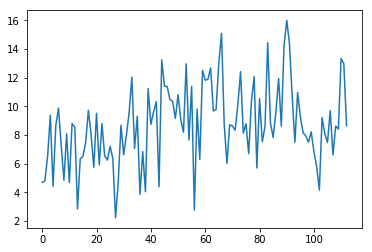

In [54]:
plt.plot(lasso_rmse)